In [16]:
import pandas as pd
import numpy as np
from utils import display_eval, analyze_protein_gen_helper

In [17]:
pretrained_file = 'data/distribution_data/original_old_10_0.5_0_results_merge.csv' 
drakes_file = 'data/distribution_data/original_new_10_0.5_0_results_merge.csv' 
df_pre = pd.read_csv(pretrained_file)
df_drakes = pd.read_csv(drakes_file)

print("---Pretrained---")
pre_stats = display_eval(df_pre)
print()
print("-----DRAKES-----")
drakes_stats = display_eval(df_drakes)

---Pretrained---
Pred-ddG (median)↑: -0.507
%(ddG > 0) (%)↑: 36.7
scRMSD (median)↓: 0.834
%(scRMSD < 2)(%)↑: 90.0
Success Rate (%)↑: 34.4

-----DRAKES-----
Pred-ddG (median)↑: 1.084
%(ddG > 0) (%)↑: 86.6
scRMSD (median)↓: 0.913
%(scRMSD < 2)(%)↑: 92.4
Success Rate (%)↑: 79.4


In [18]:
def analyze_protein_gen(protein_name):
  analyze_protein_gen_helper(protein_name, [df_pre, df_drakes], ['Pretrained', 'DRAKES'], ['#E6D983', '#0C8CE1'])

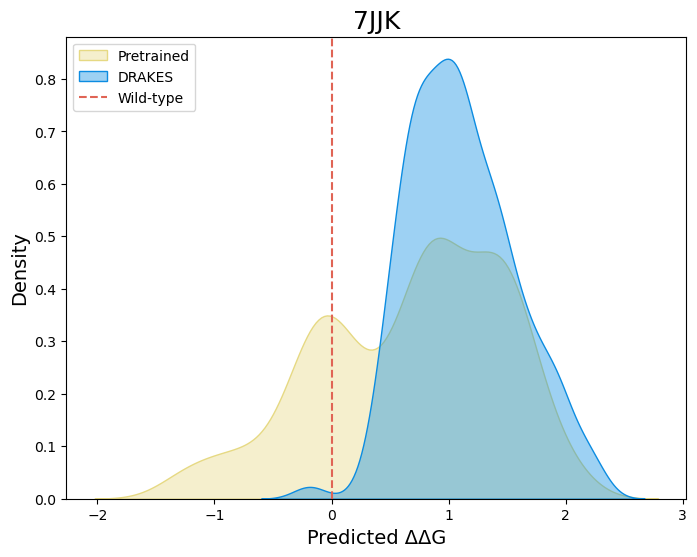

In [19]:
analyze_protein_gen('7JJK')

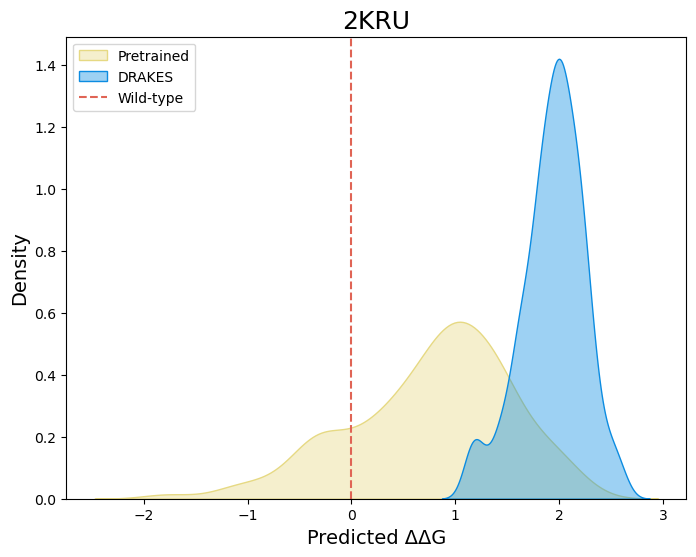

In [20]:
analyze_protein_gen('2KRU')